### Recap: how do we deal with temporal nature of claims data? 
While it's easy to define a time period of interest for a **treated** person, recall that for unexposed (control) people, there's no obvious comparison point (figure again below).


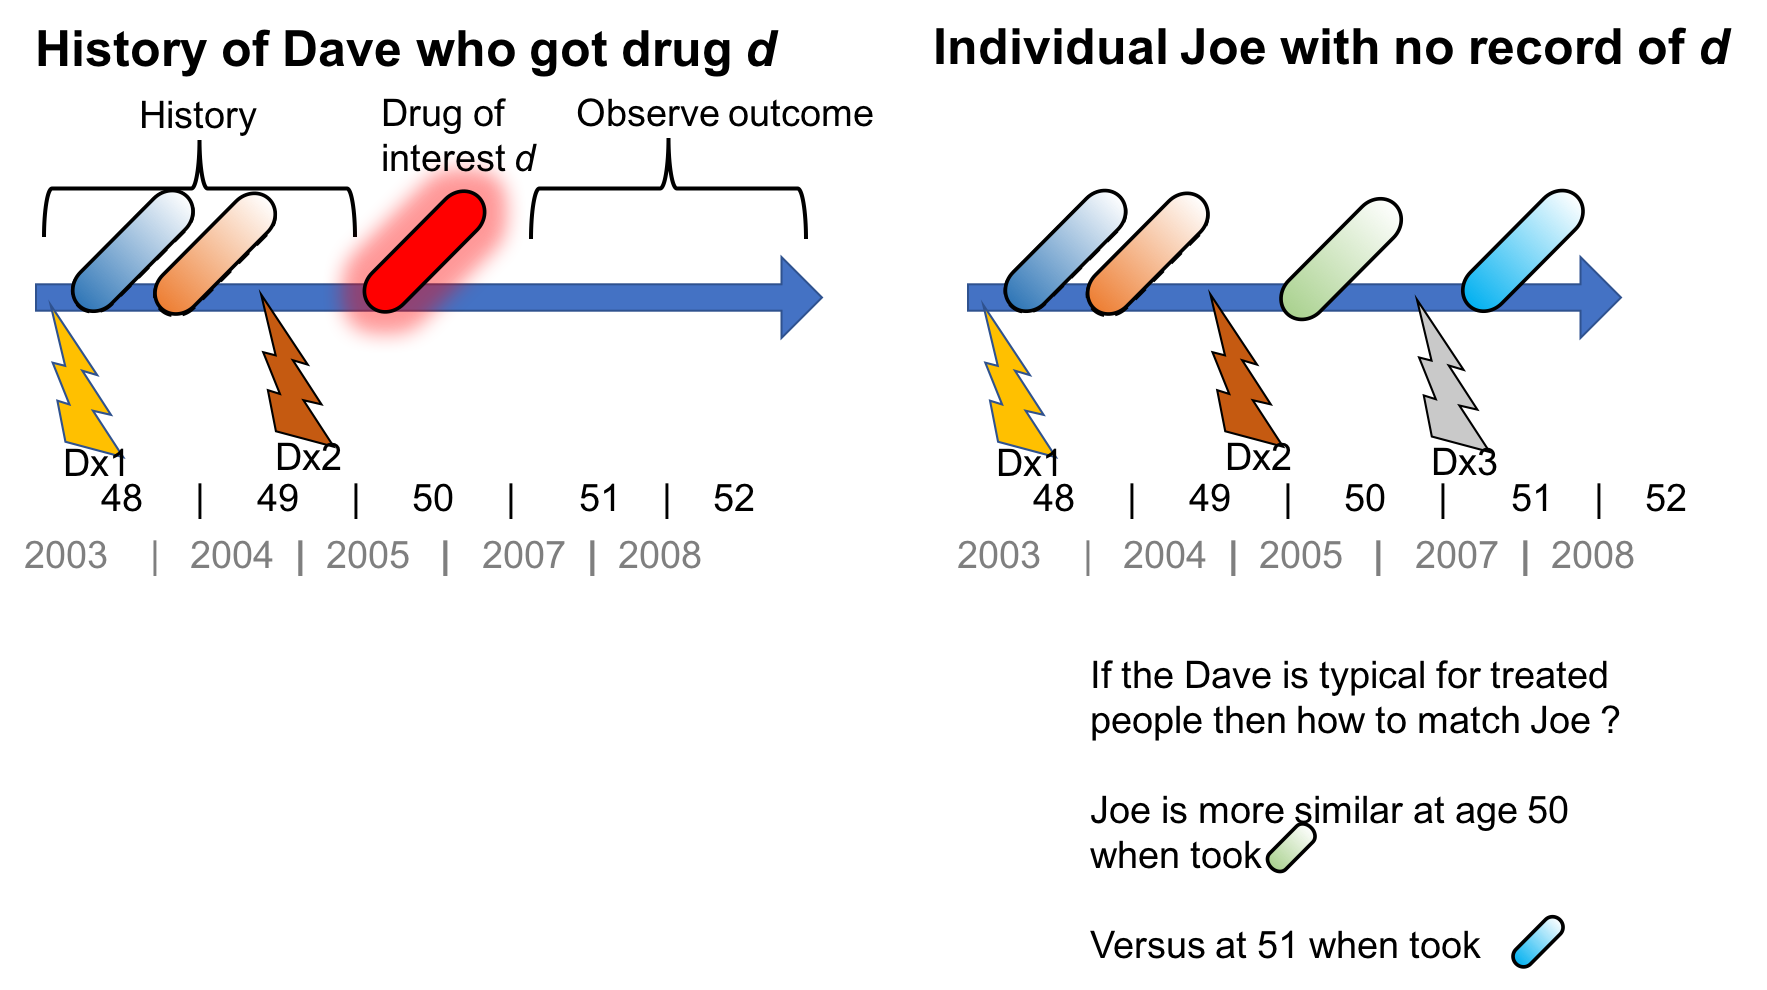

In [14]:
# Fig 1
from IPython.display import Image 
Image(filename='png/temporal_match.png',width=600)

Two approaches I was considering are:

1. Randomly sampling from unexposed people: what I talk about below.
2. Using all observed data instead of sampling: using something like marginal structural models to evaluate whole treatment history of each person. Still under consideration.

### Randomly sampling time periods from unexposed people
Let's say for now that we want to compare the one year after treatment with a control period of one year.  

#### Generating a population
We'll start with the best case scenario for recovering the effect. Imagine you have some set of people with identical medical history up to time *j*, and no history of cancer (*Y*) or drug (*D*).  At any point *j* in time these people have:
- Identical probability of receiving drug *D*: ($p_j(D)$) at each time point *j*, given no prior treatment and no prior cancer.
- Identical probability of getting cancer *Y*: ($p_j(Y)$) at each time point *j*, given no prior cancer.

We are only interested medical treatment that occurs before cancer, and once someone is treated, we assume that they remain treated (and cannot count as Control).  Then, treatments after an Rx for *D* don't count, and any treatment after cancer *Y* does not count. If each person gets some drug for each of the 4 years from 2003 through 2006, then below are some of the medical histories possible: 

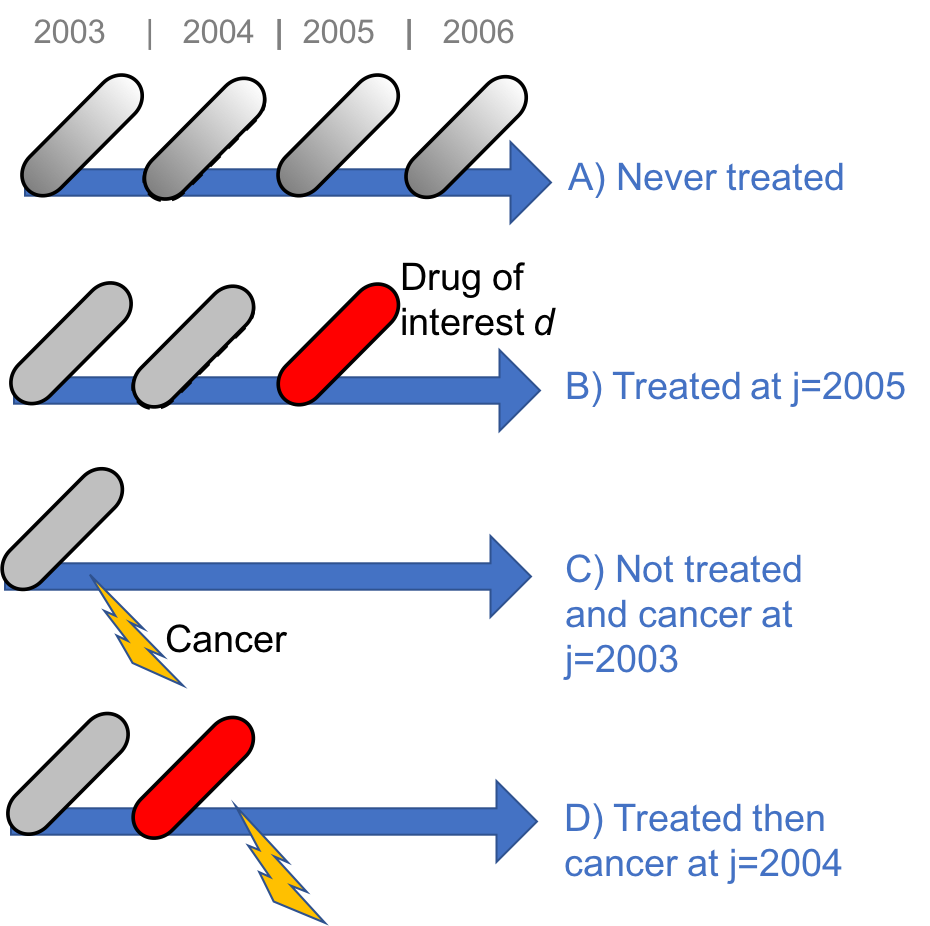

In [5]:
# Fig 2
Image(filename='png/identical_histories.png',width=400)

We can generate a population of these medical histories, starting with $N_{2003} = 1000$ people at 2003. As in the flow chart below, in each year, $N_{T,j} = p_j(D)\cdot N_{j}$ are treated, and the rest are untreated.  Of the $N_{C,j}$ who remain untreated, $Y_{C,j} = p_j(Y) \cdot N_{C,j} $ get cancer from time $j$ to $j+1$, and thus $N_{j+1} = (1 - p_j(Y) ) \cdot N_{C,j} $ remain in the population of interest for the next period. 

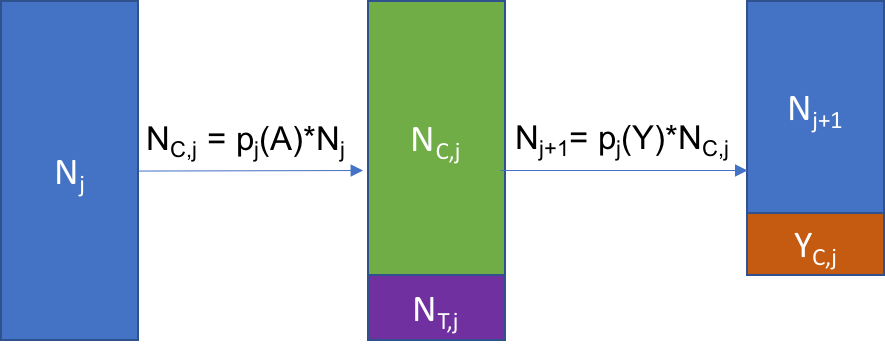

In [10]:
Image(filename='png/generation.png',width=400)

In [23]:
pD = np.array([.01, .02, .05, .1])
pY = np.array([.05, .04, .06, .02])
effect = 1.5 # Relative risk
N = 1000
pop = pd.DataFrame(index = range(len(pD)), columns = ['year','n_T','n_C','y_T','y_C'])
for j in range(len(pD)):
    nC = (1-pD[j])*N  ## pop. not treated at time j, no cancer yet 
    nT = pD[j]*N      ## pop. first treated at time j, no cancer yet
    pop.loc[j,:] = np.array([2003 + j, nT, nC, 
                              (pY[j]*effect)*nT, ## Num. treated who get cancer in the next interval
                              pY[j]*nC ## Num. untreated who get cancer in next interval & thus removed from N_{j+1} 
                             ])
    N = (1-pY[j])*nC
    
pop['neverTreated'] = [pop.iloc[i,:]['n_C'] - pop.iloc[(i+1):(pop.shape[0]),:]['n_T'].sum() 
                            for i in range(pop.shape[0])]

Then, here is the sample generated above:

In [19]:
pop

,year,n_T,n_C,y_T,y_C,neverTreated
0,2003,10,990,0.75,49.5,847.934240
1,2004,18.81,921.69,1.1286,36.8676,798.434240
2,2005,44.2411,840.581,3.9817,50.4349,761.566640
3,2006,79.0146,711.132,2.37044,14.2226,711.131763


The column "neverTreated" shows the number of people in the Control group who could have received a qualifying treatment in a given year.   That is, at that year, they have no history of cancer or drug.

For example, person (A) and person (C) who were never treated in Fig. 2 are both observed in 2003. Since person (C) gets cancer in 2003, subsequent treatments for drug of interest *D* are not under consideration.  But person (A) could have had an Rx for *D* in 2004, 2005, and 2006 as well.  

Thus a random sample of an observed period for person (C) could only start in year 2003, while person (A) could be sampled in any of the 4 years.

#### Generating a random sample
Next, we create a sample as follows:
- For each treated person, select the year of treatment for the sample
- For each never-treated control person, randomly select one of the years in which they could have been treated (that is, with no history of cancer). So for the 711.13 people who were observed for all 4 years, we sample 711.13/4 = 177.78 in each of 2003, 2004, 2005, 2006; and so on for each of the 50.4 people who were observed for only the first 3 years, etc. 

In [30]:
# selection of never-treated controls
controls = np.zeros(pop.shape[0])
totPlaced = 0
for i in range(samp.shape[0]-1,-1,-1):
    toPlace = pop['neverTreated'][i] - totPlaced
    controls[:(i + 1)] += toPlace/(i + 1)
    totPlaced += toPlace
    
# put together the sample
samp = pd.DataFrame({'year':pop['year'],
                     's_T':pop['n_T'], # number Treated in sample in each year-- same as in population
                     'sy_T':pop['n_T']*pY*effect, # number of cancer cases in Treated-- also same 
                     's_C':controls, # number Controls in sample in each year
                    'sy_C':controls*pY})
samp['propensity'] = samp['s_T']/(samp['s_T'] + samp['s_C']) 

samp

,s_C,s_T,sy_C,sy_T,year,propensity
0,262.528366,10,13.126418,0.75,2003,0.0366934
1,213.028366,18.81,8.521135,1.1286,2004,0.0811341
2,194.594566,44.2411,11.675674,3.9817,2005,0.185237
3,177.782941,79.0146,3.555659,2.37044,2006,0.307692


The last column "propensity" simply compares the treated & control in the sample.  Note that this "propensity" no longer represents the true propensity ($p_j(A)$) for getting the drug, but only the propensity in this sample population. 

#### Estimating the effect from the sample
Since people who got the drug are fully comparable to those who did not get the drug, we can then estimate the effect (we generated the data with relative risk = 1.5)

In [25]:
eYt = ((samp['sy_T'])/samp['propensity']).sum()
eYc = ((samp['sy_C'])/(1-samp['propensity'])).sum()
pseudopop_size = (samp['s_T']/samp['propensity']).sum()
print 'pseudopopulation size = ', pseudopop_size
print 'effect estimate = ', (eYt/pseudopop_size)/(eYc/pseudopop_size)

pseudopopulation size =  1000.0
effect estimate =  1.5


### So, next steps
The key thing then is to be able to create an unbiased well specified propensity score, using logistic regression and/or deep learning.  Then for any sample, even if it's throwing out most of the data, it should be able to recover the effect.  

How do we know if we have a good propensity score? Obviously you can do cross-validation to see how well you predict treatment but the more important thing is that it is able to create comparable populations with respect to their **future outcomes**. For example, we could see if we detect an effect for future first-diagnoses of ie, depression, or arthritis (or a whole set of controls *N*), as in this figure from [Lipsitch et al, "Negative Controls: A Tool for Detecting Confounding and Bias in Observational Studies"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3053408/)

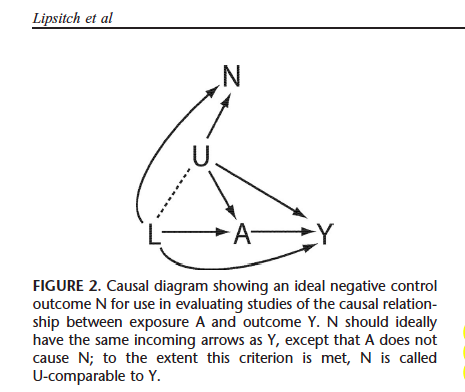

In [27]:
Image(filename='png/lipsitch.png',width=400)